In [1]:
import os
import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def load_and_merge(data_dir, lab_files, demo_path):
    # 1) load each lab file
    labs = {}
    for fn in lab_files:
        key = fn.replace("_processed.csv", "")
        df = pd.read_csv(os.path.join(data_dir, fn))
        print(f"→ {key}: {df.shape[0]} rows")
        labs[key] = df

    # drop empty questionnaire early
    labs.pop("fasting_questionnaire", None)

    # 2) inner‐merge all labs on seqn
    merged = None
    for df in labs.values():
        merged = df if merged is None else merged.merge(df, on="seqn", how="inner")
    print(f"Merged labs: {merged.shape}")

    # 3) drop any leftover NaNs
    merged = merged.dropna()
    print(f"After dropna: {merged.shape}")

    # 4) bring in demographics
    demo = pd.read_sas(demo_path, format="xport")[["SEQN", "RIDAGEYR", "RIAGENDR"]]
    demo.columns = demo.columns.str.lower()
    merged.columns = merged.columns.str.lower()
    merged = merged.merge(demo, on="seqn", how="left")
    merged.rename(columns={"ridageyr": "age", "riagendr": "gender"}, inplace=True)

    print("Cols after demo:", merged.columns.tolist())
    return merged

In [3]:
def preprocess(df):
    # drop any lab columns you know you won't use
    drop_cols = [
        "lbxhcot", "lbxhscrp", "lbxirn", "lbdirnsi", "lbxuib", "lbdglusi",
        # add more if desired...
    ]
    for c in drop_cols:
        if c in df.columns:
            df = df.drop(columns=c)

    # define X & y
    X = df[["age", "gender", "wtsafprp"]].copy()
    y = df[["lbxglu", "lbxgh"]].copy()

    # impute without chained‐assignment
    for col in X.columns:
        if pd.api.types.is_numeric_dtype(X[col]):
            X[col] = X[col].fillna(X[col].median())
        else:
            X[col] = X[col].fillna(X[col].mode()[0])

    return X, y

In [4]:
def train_and_evaluate(X, y, do_grid=False):
    # split
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

    # scale X
    sx = StandardScaler().fit(Xtr)
    Xtr_s = sx.transform(Xtr)
    Xte_s = sx.transform(Xte)

    # scale y on train only (so we can invert)
    sy = StandardScaler().fit(ytr)
    ytr_s = sy.transform(ytr)

    # base model
    base = RandomForestRegressor(random_state=42)
    model = MultiOutputRegressor(base)

    if do_grid:
        grid = {
            "estimator__n_estimators": [50,100,150],
            "estimator__max_depth":    [None,5,10],
            "estimator__min_samples_split": [2,5],
            "estimator__min_samples_leaf":  [1,2],
        }
        gs = GridSearchCV(model, grid, cv=5,
                          scoring="neg_mean_squared_error",
                          n_jobs=-1, verbose=1)
        gs.fit(Xtr_s, ytr_s)
        model = gs.best_estimator_
        print("Best params:", gs.best_params_)
    else:
        model.fit(Xtr_s, ytr_s)

    # predict (scaled), then invert to original
    y_pred_s = model.predict(Xte_s)
    y_pred   = sy.inverse_transform(y_pred_s)

    # also scale y_test for “pure” scaled‐space metrics
    yte_s = sy.transform(yte)

    # metrics in original mg/dL units
    mse_orig = mean_squared_error(yte, y_pred)
    mae_orig = mean_absolute_error(yte, y_pred)

    # metrics in scaled‐space
    mse_s    = mean_squared_error(yte_s, y_pred_s)
    mae_s    = mean_absolute_error(yte_s, y_pred_s)

    print("\n=== Original‐unit metrics ===")
    print(f"MSE   : {mse_orig:.3f}  (mg/dL²)")
    print(f"MAE   : {mae_orig:.3f}  (mg/dL)")

    print("\n=== Scaled‐unit metrics ===")
    print(f"MSE_s : {mse_s:.3f}")
    print(f"MAE_s : {mae_s:.3f}")

    return model, sx, sy

In [5]:
def main():
    data_dir = "/Users/aakashsuresh/fairness/processed_data_nhanes_lab/"
    lab_files = [
        "fasting_questionnaire_processed.csv",
        "fasting_glucose_processed.csv",
        "glycohemoglobin_processed.csv",
        "biochemistry_profile_processed.csv",
        "iron_status_processed.csv",
        "c_reactive_protein_processed.csv",
        "cotinine_processed.csv",
    ]
    demo_path = "P_DEMO.xpt"

    df = load_and_merge(data_dir, lab_files, demo_path)
    X, y = preprocess(df)
    train_and_evaluate(X, y, do_grid=False)  # flip to True to tune

if __name__ == "__main__":
    main()

→ fasting_questionnaire: 0 rows
→ fasting_glucose: 4744 rows
→ glycohemoglobin: 9737 rows
→ biochemistry_profile: 9258 rows
→ iron_status: 9453 rows
→ c_reactive_protein: 11614 rows
→ cotinine: 11395 rows
Merged labs: (4526, 59)
After dropna: (4526, 59)
Cols after demo: ['seqn', 'wtsafprp', 'lbxglu', 'lbdglusi', 'lbxgh', 'lbxsatsi', 'lbdsatlc', 'lbxsal', 'lbdsalsi', 'lbxsapsi', 'lbxsassi', 'lbxsc3si', 'lbxsbu', 'lbdsbusi', 'lbxsclsi', 'lbxsck', 'lbxscr', 'lbdscrsi', 'lbxsgb', 'lbdsgbsi', 'lbxsgl', 'lbdsglsi', 'lbxsgtsi', 'lbdsgtlc', 'lbxsir', 'lbdsirsi', 'lbxsldsi', 'lbxsossi', 'lbxsph', 'lbdsphsi', 'lbxsksi', 'lbxsnasi', 'lbxstb', 'lbdstbsi', 'lbdstblc', 'lbxsca', 'lbdscasi', 'lbxsch', 'lbdschsi', 'lbxstp', 'lbdstpsi', 'lbxstr', 'lbdstrsi', 'lbxsua', 'lbdsuasi', 'lbxirn', 'lbdirnsi', 'lbxuib', 'lbduiblc', 'lbduibsi', 'lbdtib', 'lbdtibsi', 'lbdpct', 'lbxhscrp', 'lbdhrplc', 'lbxcot', 'lbdcotlc', 'lbxhcot', 'lbdhcolc', 'age', 'gender']

=== Original‐unit metrics ===
MSE   : 828.321  (mg/

→ fasting_questionnaire: 0 rows
→ fasting_glucose: 4744 rows
→ glycohemoglobin: 9737 rows
→ biochemistry_profile: 9258 rows
→ iron_status: 9453 rows
→ c_reactive_protein: 11614 rows
→ cotinine: 11395 rows
Merged labs: (4526, 59)
After dropna: (4526, 59)
Cols after demo: ['seqn', 'wtsafprp', 'lbxglu', 'lbdglusi', 'lbxgh', 'lbxsatsi', 'lbdsatlc', 'lbxsal', 'lbdsalsi', 'lbxsapsi', 'lbxsassi', 'lbxsc3si', 'lbxsbu', 'lbdsbusi', 'lbxsclsi', 'lbxsck', 'lbxscr', 'lbdscrsi', 'lbxsgb', 'lbdsgbsi', 'lbxsgl', 'lbdsglsi', 'lbxsgtsi', 'lbdsgtlc', 'lbxsir', 'lbdsirsi', 'lbxsldsi', 'lbxsossi', 'lbxsph', 'lbdsphsi', 'lbxsksi', 'lbxsnasi', 'lbxstb', 'lbdstbsi', 'lbdstblc', 'lbxsca', 'lbdscasi', 'lbxsch', 'lbdschsi', 'lbxstp', 'lbdstpsi', 'lbxstr', 'lbdstrsi', 'lbxsua', 'lbdsuasi', 'lbxirn', 'lbdirnsi', 'lbxuib', 'lbduiblc', 'lbduibsi', 'lbdtib', 'lbdtibsi', 'lbdpct', 'lbxhscrp', 'lbdhrplc', 'lbxcot', 'lbdcotlc', 'lbxhcot', 'lbdhcolc', 'age', 'gender']

=== Original‐unit metrics ===
MSE   : 828.321  (mg/

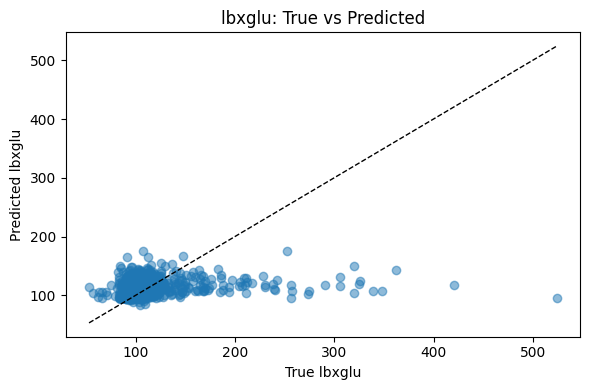

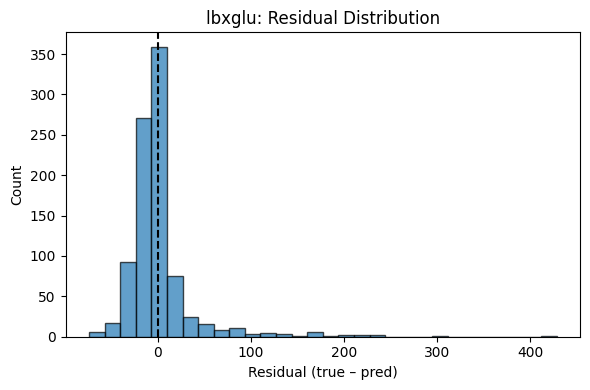

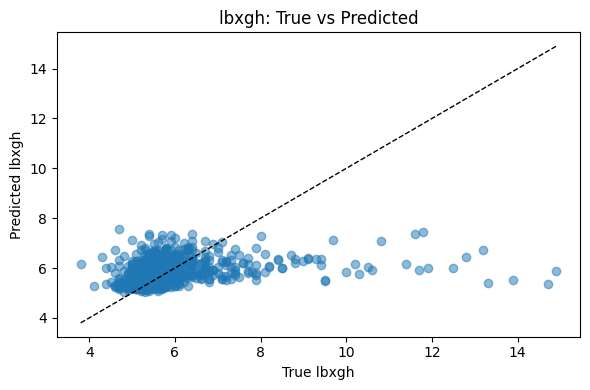

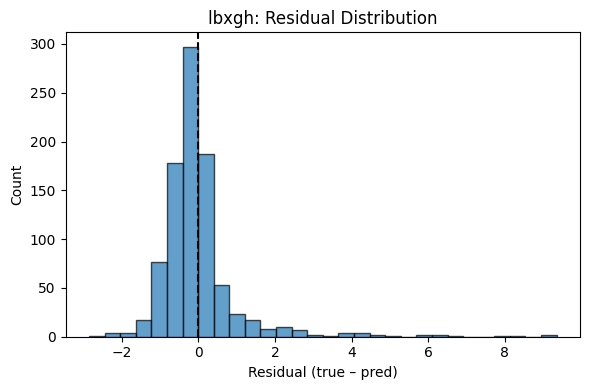

In [6]:
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import RobustScaler

def train_and_evaluate_improved(X, y):
    # 1) train/test split
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

    # 2) robustly scale X (less sensitive to outliers)
    rx = RobustScaler().fit(Xtr)
    Xtr_r = rx.transform(Xtr)
    Xte_r = rx.transform(Xte)

    # 3) Multi‐output Gradient‐Boosted Trees
    base = HistGradientBoostingRegressor(random_state=42)
    model = MultiOutputRegressor(base)
    model.fit(Xtr_r, ytr)

    # 4) predict
    y_pred = model.predict(Xte_r)

    # 5) compute original‐unit metrics
    mse = mean_squared_error(yte, y_pred)
    mae = mean_absolute_error(yte, y_pred)
    print("\n=== Improved model metrics ===")
    print(f"MSE   : {mse:.3f}  (mg/dL²)")
    print(f"MAE   : {mae:.3f}  (mg/dL)")

    # 6) residual analysis
    residuals = yte.values - y_pred
    targets = y.columns.tolist()
    for i, name in enumerate(targets):
        plt.figure(figsize=(6,4))
        plt.scatter(yte.iloc[:,i], y_pred[:,i], alpha=0.5)
        plt.plot([yte.iloc[:,i].min(), yte.iloc[:,i].max()],
                 [yte.iloc[:,i].min(), yte.iloc[:,i].max()],
                 'k--', lw=1)
        plt.xlabel(f"True {name}")
        plt.ylabel(f"Predicted {name}")
        plt.title(f"{name}: True vs Predicted")
        plt.tight_layout()

        plt.figure(figsize=(6,4))
        plt.hist(residuals[:,i], bins=30, edgecolor='k', alpha=0.7)
        plt.axvline(0, color='k', linestyle='--')
        plt.xlabel("Residual (true – pred)")
        plt.ylabel("Count")
        plt.title(f"{name}: Residual Distribution")
        plt.tight_layout()

    return model

def main():
    data_dir = "/Users/aakashsuresh/fairness/processed_data_nhanes_lab/"
    lab_files = [
        "fasting_questionnaire_processed.csv",
        "fasting_glucose_processed.csv",
        "glycohemoglobin_processed.csv",
        "biochemistry_profile_processed.csv",
        "iron_status_processed.csv",
        "c_reactive_protein_processed.csv",
        "cotinine_processed.csv",
    ]
    demo_path = "P_DEMO.xpt"

    df = load_and_merge(data_dir, lab_files, demo_path)
    X, y = preprocess(df)
    train_and_evaluate(X, y, do_grid=False)  # flip to True to tune

    df = load_and_merge(data_dir, lab_files, demo_path)
    X, y = preprocess(df)

    # original RF
    _ = train_and_evaluate(X, y, do_grid=False)

    # improved GBDT + robust scaling
    _ = train_and_evaluate_improved(X, y)

if __name__ == "__main__":
    main()